In [ ]:
pip install yfinance numpy pandas scipy matplotlib

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import math
from dataclasses import dataclass
from typing import List, Optional, Tuple

import numpy as np
import pandas as pd
import yfinance as yf
from scipy.interpolate import UnivariateSpline

In [ ]:
TICKERS = [
    "ADBE","AMD","BCS","CAT","DUK","ENEL.MI","LLY","LMT","MSFT","NEM","PFE","QCOM","SHW","UBS","UNH"
]
BENCH_TICKER = "ACWI"       # proxy WLS
START = "2015-01-01"
END = None

In [ ]:
LOOKBACK_DAYS = 60          # finestra segnali
REBALANCE_FREQ = "W-FRI"    # ribilanciamento settimanale
AGGRESSIVE = True           # ITSM aggressivo: 1.0/0.5/0.0
SMOOTHING = 1e-3            # smoothing spline (stabilizzato da standardizzazione)
MAX_WEIGHT = 0.20           # cap 20% per titolo
PRINT_TOP = 15              # quanti pesi mostrare
PRINT_LAST_N_REBAL = 5      # quanti rebalance riepilogare

# Composite score params
ROC_LB = 10
RSI_LB = 7
ATRP_MAX = 0.07           # filtro volatilità: ATR% <= ATRP_MAX
CONFIRM_THRESHOLD = 4     # soglia score 0..6 per confermare ITSM
TOP_N = 5                 # quanti titoli tenere (ranking)
SLOW_ROC_LB = 63          # ~3 mesi per ROC "slow"
RISK_EMA = 100            # EMA regime filter (benchmark)
EXPO_RISK_ON = 1.0        # esposizione se risk-on
EXPO_RISK_OFF = 0.5       # esposizione se risk-off (metti 0.0 se vuoi stare cash)
TARGET_VOL = 0.15         # vol target annualizzata
VT_WINDOW = 63            # finestra per realized vol (3 mesi)
ALLOW_CASH = False        # True: consente cash dopo scaling vol (no rinormalizzazione)
EXPO_RISK_OFF = 1.0

In [ ]:
@dataclass
class Perf:
    cagr: float
    sharpe: float
    maxdd: float
    vol: float
    total_return: float


def perf_stats(equity: pd.Series) -> Perf:
    rets = equity.pct_change().dropna()
    if rets.empty or equity.iloc[0] <= 0:
        return Perf(0,0,0,0,0)
    ann = 252
    cagr = (equity.iloc[-1] / equity.iloc[0]) ** (ann / len(rets)) - 1
    vol = rets.std() * np.sqrt(ann)
    sharpe = (rets.mean() / rets.std()) * np.sqrt(ann) if rets.std() > 0 else 0
    dd = (equity / equity.cummax() - 1).min() if len(equity) > 1 else 0
    total = equity.iloc[-1] / equity.iloc[0] - 1
    return Perf(cagr, sharpe, dd, vol, total)

In [ ]:
def dl_prices_ohlcv(tickers: List[str], start: Optional[str], end: Optional[str]) -> pd.DataFrame:

    data = {}
    skipped = []
    for t in tickers:
        try:
            df = yf.download(t, start=start, end=end, interval="1d", auto_adjust=True, progress=False)
            if df.empty:
                skipped.append(t); continue
            df = df[['Open','High','Low','Close','Volume']].sort_index().ffill()
            df = df.rename(columns={c: f"{c}|{t}" for c in df.columns})
            data[t] = df
        except Exception:
            skipped.append(t)
    if skipped:
        print("  Skippati (nessun dato OHLCV):", ", ".join(skipped))
    if not data:
        raise ValueError("Nessun dato OHLCV scaricato.")

    out = pd.concat(data.values(), axis=1).sort_index()
    return out

In [ ]:
def get_field(df_flat: pd.DataFrame, field: str) -> pd.DataFrame:

    cols = []
    for c in df_flat.columns:
        if isinstance(c, tuple):
            if len(c) >= 1 and str(c[0]) == field:
                cols.append(c)
        else:
            s = str(c)
            if s.startswith(f"{field}|"):
                cols.append(c)

    if not cols:
        return pd.DataFrame(index=df_flat.index)

    out = df_flat[cols].copy()

    new_cols = []
    for c in cols:
        if isinstance(c, tuple):
            new_cols.append(str(c[-1]))
        else:
            s = str(c)
            parts = s.split("|", 1)
            new_cols.append(parts[1] if len(parts) > 1 else s)

    out.columns = new_cols
    return out


def drop_ticker(df_flat: pd.DataFrame, ticker: str) -> pd.DataFrame:

    to_drop = []
    for c in df_flat.columns:
        if isinstance(c, tuple):
            if len(c) >= 2 and str(c[-1]) == ticker:
                to_drop.append(c)
        else:
            if str(c).endswith(f"|{ticker}"):
                to_drop.append(c)
    return df_flat.drop(columns=to_drop, errors="ignore")

In [ ]:
# ITSM (spline su finestra standardizzata)
def itsm_signal_from_window(px: np.ndarray, smoothing: float, aggressive: bool) -> float:

    n = len(px)
    if n < 20:
        return 0.0
    arr = np.array(px, dtype=float)
    if np.all(arr > 0):
        arr = np.log(arr)
    mu, sd = arr.mean(), arr.std()
    if sd > 0:
        arr = (arr - mu) / sd

    u = np.linspace(0.0, 1.0, n)
    try:
        spl = UnivariateSpline(u, arr, s=smoothing, k=3)
    except Exception:
        return 0.0
    d1 = float(spl.derivative(1)(1.0))
    d2 = float(spl.derivative(2)(1.0))

    if aggressive:
        if d1 >= 0 and d2 >= 0:
            return 1.0
        elif d1 >= 0 and d2 < 0:
            return 0.5
        else:
            return 0.0
    else:
        return 1.0 if (d1 >= 0 and d2 >= 0) else 0.0


# INDICATORI TECNICI (OHLCV)
def _ema(s, n):
    return s.ewm(span=n, adjust=False, min_periods=n).mean()

def _rsi(close, n=7):
    delta = close.diff()
    up = delta.clip(lower=0.0)
    down = (-delta).clip(lower=0.0)
    rs = up.rolling(n, min_periods=n).mean() / down.rolling(n, min_periods=n).mean()
    return 100 - (100 / (1 + rs))

def _atr(high, low, close, n=14):
    prev_c = close.shift(1)
    tr = pd.concat([(high - low).abs(), (high - prev_c).abs(), (low - prev_c).abs()], axis=1).max(axis=1)
    return tr.rolling(n, min_periods=n).mean()

def _mfi(high, low, close, vol, n=14):
    tp = (high + low + close) / 3.0
    raw = tp * vol
    pos = raw.where(tp > tp.shift(1), 0.0)
    neg = raw.where(tp < tp.shift(1), 0.0)
    r = pos.rolling(n, min_periods=n).sum() / neg.rolling(n, min_periods=n).sum()
    return 100 - (100 / (1 + r))

def _obv(close, vol):
    sign = np.sign(close.diff()).fillna(0.0)
    return (sign * vol.fillna(0.0)).cumsum()

def _macd_hist(close, fast=12, slow=26, sig=9):
    ema_fast = _ema(close, fast)
    ema_slow = _ema(close, slow)
    macd = ema_fast - ema_slow
    signal = macd.ewm(span=sig, adjust=False, min_periods=sig).mean()
    return macd - signal


# COMPOSITE SCORE (0..6) + filtri
def compute_composite_signals_window(sub_px: pd.DataFrame,
                                     bench_px: Optional[pd.Series],
                                     atrp_max: float = ATRP_MAX,
                                     roc_lb: int = ROC_LB,
                                     rsi_lb: int = RSI_LB) -> pd.Series:

    required_fields = {"High","Low","Close","Volume"}
    if not isinstance(sub_px.columns, pd.MultiIndex) or not required_fields.issubset({c[0] for c in sub_px.columns}):
        raise ValueError("Atteso DataFrame con colonne MultiIndex (field, ticker) e campi OHLCV completi.")

    tickers = sorted({t for (_, t) in sub_px.columns})
    scores = pd.Series(0.0, index=tickers, dtype=float)

    bench_roc = None
    if bench_px is not None and len(bench_px) >= roc_lb + 1:
        bench_roc = (bench_px.iloc[-1] - bench_px.iloc[-1-roc_lb]) / bench_px.iloc[-1-roc_lb]

    for t in tickers:
        c = sub_px[("Close", t)].dropna()
        if len(c) < max(26, roc_lb+1, rsi_lb+1, 20):
            scores[t] = 0.0
            continue

        h = sub_px[("High", t)]
        l = sub_px[("Low", t)]
        v = sub_px[("Volume", t)]

        # 1) ROC(10)
        roc = (c.iloc[-1] - c.iloc[-1-roc_lb]) / c.iloc[-1-roc_lb]

        # 2) EMA(5/20)
        ema5 = _ema(c, 5).iloc[-1]
        ema20 = _ema(c, 20).iloc[-1]

        # 3) MACD histogram + incremento
        mh = _macd_hist(c)
        macdh = mh.iloc[-1]
        macdh_prev = mh.iloc[-2] if len(mh) >= 2 else np.nan
        macdh_up = (macdh > 0) and (not np.isnan(macdh_prev)) and (macdh_prev < macdh)

        # 4) RSI(7)
        rsi = _rsi(c, n=rsi_lb).iloc[-1]

        # 5) MFI(14)
        if v.fillna(0).sum() > 0:
            mfi = _mfi(h, l, c, v, n=14).iloc[-1]
        else:
            mfi = np.nan  # se volumi inaffidabili, niente punto

        # 6) ATR% filtro
        atr = _atr(h, l, c, n=14).iloc[-1]
        atrp = float(atr / c.iloc[-1]) if c.iloc[-1] > 0 else np.inf

        # 7) OBV slope (5)
        obv = _obv(c, v)
        obv_slope = obv.diff(5).iloc[-1] if len(obv) >= 6 else 0.0

        # Relative strength vs bench
        rs_ok = True
        if bench_roc is not None and not np.isnan(bench_roc):
            rs_ok = (roc > bench_roc)

        # Punteggi (0/1) come matrice proposta
        sc = 0
        sc += int(roc > 0)
        sc += int(ema5 > ema20)
        sc += int(macdh_up)
        sc += int(rsi > 50)
        sc += int((not np.isnan(mfi)) and (mfi > 55))
        sc += int(obv_slope > 0)

        # Filtro volatilità e RS vs benchmark
        if (atrp > atrp_max) or (not rs_ok):
            sc = 0

        scores[t] = sc

    return scores  # 0..6


# ==========================
# WEIGHTS
# ==========================
def build_weight_vector(signals: pd.Series, max_weight: float) -> pd.Series:

    base = pd.Series(0.0, index=signals.index, dtype=float)
    longs = signals[signals > 0]
    if longs.empty:
        return base
    w = (longs / longs.sum()).clip(upper=max_weight)
    if w.sum() <= 0:
        return base
    w = w / w.sum()
    base.loc[w.index] = w.values
    return base

In [ ]:
def gap_quality_score(open_ser: pd.Series, high_ser: pd.Series, low_ser: pd.Series, close_ser: pd.Series,
                      lookback_break: int = 60, gap_thr: float = 0.06) -> float:

    if len(close_ser) < max(lookback_break+2, 20):
        return 0.0
    # giorno di riferimento = t-1
    c_t1 = close_ser.iloc[-1]
    o_t1 = open_ser.iloc[-1]
    c_t2 = close_ser.iloc[-2]

    # gap% del giorno t-1
    gap = (o_t1 - c_t2) / c_t2 if c_t2 > 0 else 0.0
    if gap < gap_thr:
        return 0.0

    # breakout di range multi-settimana: close_{t-1} sopra max degli ultimi N-1
    prev_max = close_ser.iloc[-(lookback_break+1):-1].max()
    breakout_ok = (c_t1 > prev_max)

    # “tenuta” del gap: close >= open (no fade totale) e low sopra close_{t-2} (gap non riempito del tutto)
    hold_ok = (c_t1 >= o_t1) and (low_ser.iloc[-1] > c_t2)

    # penalizza gap consecutivi (due gap up di fila = più rischio di esaurimento)
    if len(open_ser) >= 3:
        gap_prev = (open_ser.iloc[-2] - close_ser.iloc[-3]) / close_ser.iloc[-3] if close_ser.iloc[-3] > 0 else 0.0
        consecutive_penalty = (gap_prev >= gap_thr)
    else:
        consecutive_penalty = False

    score = 0.0
    score += 0.6 if breakout_ok else 0.0
    score += 0.4 if hold_ok else 0.0
    if consecutive_penalty:
        score *= 0.5
    return float(np.clip(score, 0.0, 1.0))

In [ ]:
# BACKTEST
def backtest_itsm(
    tickers: List[str],
    start: Optional[str],
    end: Optional[str],
    bench_ticker: Optional[str],
    lookback_days: int,
    rebalance_freq: str,
    aggressive: bool,
    smoothing: float,
    max_weight: float
) -> Tuple[pd.Series, Optional[pd.Series], pd.DataFrame]:
    """
    Backtest ITSM + Composite score (robusto a date mancanti e calendari diversi).
    Integra:
      - blend ITSM (fast) + ROC lento (~3 mesi)
      - composite come ranking (Top-N)
      - regime filter su benchmark (EMA RISK_EMA)
      - volatility targeting
      - gap quality factor (se disponibile 'Open')
    """

    # --- helper: consenti cash (somma <= 100%) ma non leva, e rispetta cap
    def _enforce_exposure_bounds(w: pd.Series,
                                 allow_cash: bool = True,
                                 max_gross: float = 1.0,
                                 cap: Optional[float] = None) -> pd.Series:
        w = pd.Series(w, dtype=float).clip(lower=0.0).fillna(0.0)
        if cap is not None:
            w = w.clip(upper=cap)
        gross = float(w.sum())
        if gross <= 0:
            return w
        if allow_cash:
            if gross > max_gross:
                w = w * (max_gross / gross)
        else:
            # vincola sempre a somma = 100%
            w = w * (max_gross / gross)
        return w

    # 1) Download OHLCV (flat)
    all_syms = list(tickers) + ([bench_ticker] if bench_ticker else [])
    ohlcv_flat = dl_prices_ohlcv(all_syms, start, end)

    close_full = get_field(ohlcv_flat, "Close")
    high_full  = get_field(ohlcv_flat, "High")
    low_full   = get_field(ohlcv_flat, "Low")
    vol_full   = get_field(ohlcv_flat, "Volume")
    open_full  = get_field(ohlcv_flat, "Open")   # per gap factor
    idx_all = close_full.index

    # 3) Benchmark separato e rimozione da universe
    bench = None
    if bench_ticker and bench_ticker in close_full.columns:
        bench = close_full[bench_ticker].dropna()
        for df in (close_full, high_full, low_full, vol_full, open_full):
            if bench_ticker in df.columns:
                df.drop(columns=[bench_ticker], inplace=True, errors="ignore")

    # 4) Filtra titoli con dati sufficienti (>= 25% delle date)
    min_obs = int(0.25 * len(close_full))
    counts = close_full.notna().sum(axis=0)
    keep = counts[counts >= min_obs].index.tolist()
    if not keep:
        raise ValueError("Nessun titolo con dati sufficienti dopo il filtro.")

    close = close_full[keep].copy()
    high  = high_full[keep].copy()
    low   = low_full[keep].copy()
    vol   = vol_full[keep].copy()
    open_ = open_full[keep].copy() if not open_full.empty else None

    print("Backtesting:", ", ".join(keep))

    # 5) Date di rebalance (solo date effettivamente presenti)
    rebal_dates = pd.date_range(idx_all.min(), idx_all.max(), freq=rebalance_freq)
    rebal_dates = [d for d in rebal_dates if d in idx_all]
    if len(rebal_dates) < 2:
        raise ValueError("Periodo troppo breve per ribilanciamenti.")

    # 6) Inizializza equity
    equity = pd.Series(index=idx_all, dtype=float)
    equity.iloc[0] = 1.0

    weights_rows: List[pd.Series] = []
    last_w = pd.Series(0.0, index=keep, dtype=float)
    last_val_date = idx_all[0]

    # 7) Loop di rebalance robusto
    for i, d in enumerate(rebal_dates):
        # indice fino al giorno d
        sub_idx = close.index[close.index <= d]
        if len(sub_idx) == 0:
            continue

        # no leakage: fino a t-1
        sub_idx_noleak = sub_idx[:-1] if len(sub_idx) > 1 else sub_idx[:0]

        if len(sub_idx_noleak) >= min(lookback_days // 2, 60):
            # finestra della lunghezza lookback_days
            window_idx = sub_idx_noleak[-lookback_days:]

            # === A) ITSM (fast) + ROC lento (3 mesi) ===
            sigs = pd.Series(0.0, index=keep, dtype=float)
            roc_long = pd.Series(0.0, index=keep, dtype=float)
            for tkr in keep:
                arr = close.loc[window_idx, tkr].dropna().values
                sigs[tkr] = itsm_signal_from_window(arr, smoothing, aggressive) if len(arr) >= 20 else 0.0

                csub = close.loc[sub_idx_noleak, tkr].dropna()
                if len(csub) >= SLOW_ROC_LB + 1:
                    roc_long[tkr] = (csub.iloc[-1] - csub.iloc[-SLOW_ROC_LB-1]) / csub.iloc[-SLOW_ROC_LB-1]
                else:
                    roc_long[tkr] = 0.0

            blend = 0.7 * sigs + 0.3 * (roc_long > 0).astype(float)   # [0..1]

            # === Composite score (stessa tua funzione) per ranking ===
            sub_px = pd.DataFrame(index=window_idx)
            for tkr in keep:
                # Open
                if open_ is not None and tkr in open_.columns:
                    open_series = open_.loc[window_idx, tkr]
                else:
                    open_series = close.loc[window_idx, tkr].shift(1).bfill()
                sub_px[("Open", tkr)]   = open_series
                sub_px[("High", tkr)]   = high.loc[window_idx, tkr]
                sub_px[("Low", tkr)]    = low.loc[window_idx, tkr]
                sub_px[("Close", tkr)]  = close.loc[window_idx, tkr]
                sub_px[("Volume", tkr)] = vol.loc[window_idx, tkr]

            sub_px.columns = pd.MultiIndex.from_tuples(sub_px.columns, names=["Field", "Ticker"])

            bench_sub = bench.loc[bench.index.intersection(window_idx)] if bench is not None else None
            comp = compute_composite_signals_window(
                sub_px, bench_sub, atrp_max=ATRP_MAX, roc_lb=ROC_LB, rsi_lb=RSI_LB
            )
            comp_norm = (comp / 6.0).clip(0, 1)

            gap_factor = pd.Series(0.0, index=keep, dtype=float)
            if open_ is not None:
                for tkr in keep:
                    cser = close.loc[window_idx, tkr]
                    if len(cser) >= 3 and tkr in open_.columns:
                        o_t1 = open_.loc[window_idx, tkr].iloc[-1]
                        c_t1 = cser.iloc[-1]
                        c_t2 = cser.iloc[-2]
                        prev_max = cser.iloc[:-1].max()
                        breakout_ok = (c_t1 > prev_max)
                        hold_ok = (c_t1 >= o_t1) and (low.loc[window_idx, tkr].iloc[-1] > c_t2)

                        score = 0.0
                        gap = (o_t1 - c_t2) / c_t2 if c_t2 > 0 else 0.0
                        score += 0.6 if (gap >= 0.06 and breakout_ok) else 0.0
                        score += 0.4 if hold_ok else 0.0

                        # penalizza gap consecutivi
                        if len(cser) >= 4:
                            o_t2 = open_.loc[window_idx, tkr].iloc[-2]
                            c_t3 = cser.iloc[-3]
                            gap_prev = (o_t2 - c_t3) / c_t3 if c_t3 > 0 else 0.0
                            if gap_prev >= 0.06:
                                score *= 0.5

                        gap_factor[tkr] = float(np.clip(score, 0.0, 1.0))

            #  D) Score continuo + ranking Top-N
            score_cont = 0.4 * blend + 0.4 * comp_norm + 0.2 * gap_factor
            eligible = score_cont[score_cont > 0]
            w = build_weight_vector(eligible, max_weight)

            #  B) Regime filter su benchmark (risk-on / risk-off)
            exposure = 1.0
            if bench is not None:
                bsub = bench.loc[bench.index < d]  # solo t-1
                if len(bsub) >= RISK_EMA:
                    ema100 = bsub.ewm(span=RISK_EMA, adjust=False, min_periods=RISK_EMA).mean().iloc[-1]
                    exposure = EXPO_RISK_ON if bsub.iloc[-1] > ema100 else EXPO_RISK_OFF
            w = w * exposure

            #  C) Volatility targeting (sul portafoglio storico)
            if equity.first_valid_index() is not None:
                hist_eq = equity.loc[:last_val_date].dropna().tail(VT_WINDOW + 1)
                if len(hist_eq) >= 2:
                    rv = hist_eq.pct_change().dropna().std() * np.sqrt(252)
                    if rv and rv > 0:
                        # evita leva implicita dallo scaling: tieni upper=1.0
                        scale = float(np.clip(TARGET_VOL / rv, 0.5, 1.0))
                        w = w * scale

            #  E) Enforcement finale pesi
            if ALLOW_CASH:
                # consente somma < 100% ma MAI > 100% (e rispetta cap)
                w = _enforce_exposure_bounds(w, allow_cash=True, max_gross=1.0, cap=max_weight)
            else:
                # --- forza fully invested = 100% rispettando cap per titolo ---
                w = pd.Series(w, index=keep, dtype=float).clip(lower=0.0).fillna(0.0)

                # normalizza a 100% se somma > 0
                if w.sum() > 0:
                    w = w / w.sum()

                # applica cap per titolo
                w = w.clip(upper=max_weight)

                # se il cap ha abbassato la somma < 100%, ridistribuisci il residuo sui titoli sotto-cap
                resid = 1.0 - float(w.sum())
                if resid > 1e-12:
                    room = (max_weight - w).clip(lower=0.0)
                    if room.sum() > 0:
                        w = w + room * (resid / room.sum())
                    # rifinitura numerica
                    if w.sum() > 0:
                        w = w / w.sum()

        else:
            w = last_w.copy()

        # salva pesi del rebalance
        w = pd.Series(w, index=keep, dtype=float).fillna(0.0)
        w.name = d
        weights_rows.append(w)

        # Performance tra d e prossimo rebalance
        next_d = rebal_dates[i + 1] if (i + 1) < len(rebal_dates) else idx_all[-1]
        mask = (close.index >= d) & (close.index <= next_d)
        period = close.loc[mask, keep]
        rets = period.pct_change().iloc[1:].fillna(0.0)

        for tstamp, row in rets.iterrows():
            port_ret = float((w * row).sum())
            equity.loc[tstamp] = equity.loc[last_val_date] * (1.0 + port_ret)
            last_val_date = tstamp

        last_w = w

    # 8) Output
    weights_df = pd.concat(weights_rows, axis=1).T if weights_rows else pd.DataFrame(columns=keep)
    bench_aligned = bench.reindex(equity.index).ffill() if bench is not None else None
    return equity.dropna(), bench_aligned, weights_df

Backtesting: ADBE, AMD, BCS, CAT, DUK, ENEL.MI, LLY, LMT, MSFT, NEM, PFE, QCOM, SHW, UBS, UNH

=== ITSM + Composite (long-only) ===
CAGR:      18.45%
Sharpe:      1.06
Vol ann.:  17.40%
Max Draw:  -28.95%
Tot Ret:   548.25%

=== Relativo a ACWI (proxy WLS) ===
CAGR(rel):  7.69%   Sharpe(rel):   0.82   MaxDD(rel): -18.14%

=== Pesi suggeriti OGGI (rebalance 2025-10-10) ===
     LLY:  14.07%
    MSFT:  12.79%
     PFE:  11.51%
     AMD:   9.97%
     UNH:   9.97%
     LMT:   8.70%
 ENEL.MI:   8.70%
     DUK:   7.67%
     CAT:   7.42%
     NEM:   2.30%
     BCS:   2.30%
     UBS:   2.30%
    QCOM:   2.30%
    ADBE:   0.00%
     SHW:   0.00%
Somma pesi: 100.00%

=== Ultimi 5 rebalance (Top 5 pesi) ===
2025-09-12: BCS:16.7%, UNH:16.4%, LLY:12.6%, LMT:10.7%, NEM:10.7%  | somma=100.0%
2025-09-19: QCOM:15.2%, LMT:12.7%, CAT:11.4%, ADBE:9.6%, LLY:9.5%  | somma=100.0%
2025-09-26: AMD:14.0%, NEM:14.0%, DUK:12.7%, LMT:12.7%, ADBE:9.1%  | somma=100.0%
2025-10-03: CAT:11.4%, ENEL.MI:10.4%, PFE:10.4%,

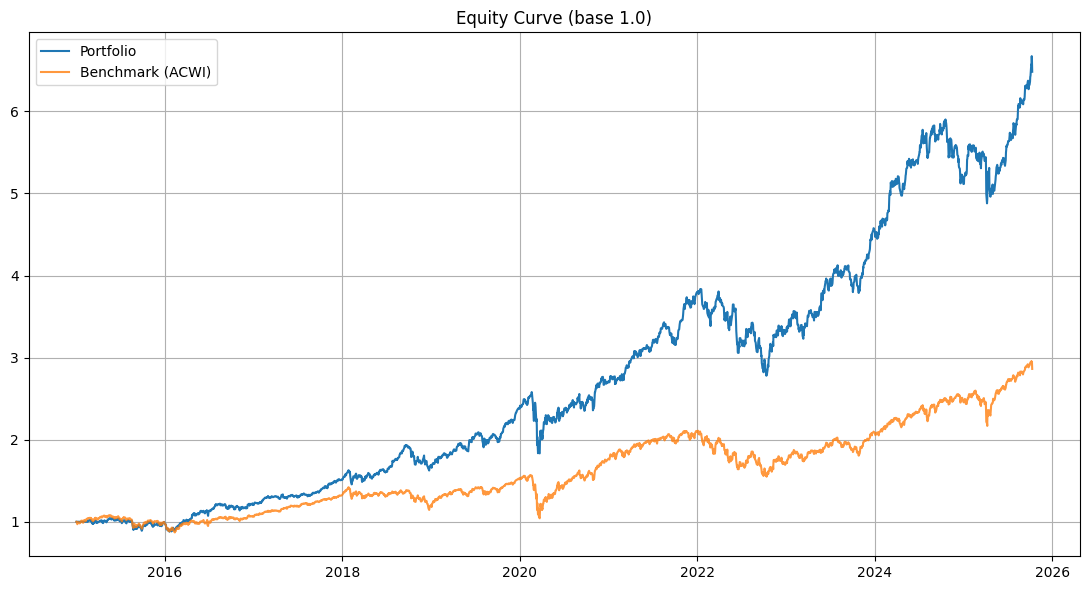

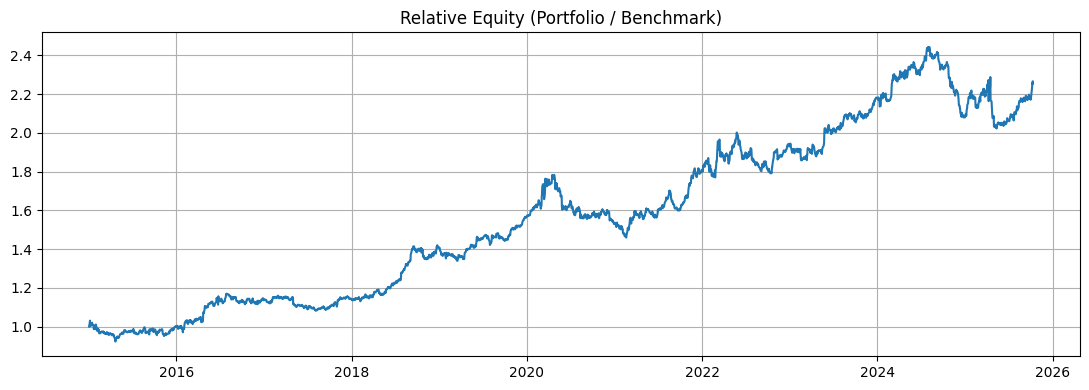


=== Simulazione rebalance a 2025-10-10 partendo da 2025-10-06 ===
(Equal weight iniziale 6.67% per titolo)

    ADBE: old= 6.67% → new= 0.00%  → SELL
     AMD: old= 6.67% → new= 9.97%  → BUY↑
     BCS: old= 6.67% → new= 2.30%  → REDUCE↓
     CAT: old= 6.67% → new= 7.42%  → BUY↑
     DUK: old= 6.67% → new= 7.67%  → BUY↑
 ENEL.MI: old= 6.67% → new= 8.70%  → BUY↑
     LLY: old= 6.67% → new=14.07%  → BUY↑
     LMT: old= 6.67% → new= 8.70%  → BUY↑
    MSFT: old= 6.67% → new=12.79%  → BUY↑
     NEM: old= 6.67% → new= 2.30%  → REDUCE↓
     PFE: old= 6.67% → new=11.51%  → BUY↑
    QCOM: old= 6.67% → new= 2.30%  → REDUCE↓
     SHW: old= 6.67% → new= 0.00%  → SELL
     UBS: old= 6.67% → new= 2.30%  → REDUCE↓
     UNH: old= 6.67% → new= 9.97%  → BUY↑


In [ ]:
# REPORTING
def print_top_weights(weights: pd.DataFrame, top: int = 10):
    if weights.empty:
        print("\nNessun peso calcolato."); return
    latest_date = weights.index[-1]
    latest = weights.iloc[-1].sort_values(ascending=False)
    print(f"\n=== Pesi suggeriti OGGI (rebalance {latest_date.date()}) ===")
    for name, val in latest.head(top).items():
        print(f"{name:>8}: {val*100:6.2f}%")
    others = max(0, len(latest) - top)
    if others:
        print(f"... e altri {others} titoli con peso minore.")
    print(f"Somma pesi: {latest.sum()*100:6.2f}%")


def print_recent_rebalances(weights: pd.DataFrame, n: int = 5):
    if weights.empty: return
    n = min(n, len(weights))
    print(f"\n=== Ultimi {n} rebalance (Top 5 pesi) ===")
    tail = weights.tail(n)
    for dt, row in tail.iterrows():
        row_sorted = row.sort_values(ascending=False)
        head = ", ".join([f"{k}:{v*100:.1f}%" for k, v in row_sorted.head(5).items()])
        print(f"{dt.date()}: {head}  | somma={row.sum()*100:.1f}%")


def compare_with_equal(weights: pd.DataFrame, start_date: str):

    if weights.empty:
        print("Nessun rebalance disponibile."); return

    start_dt = pd.Timestamp(start_date)
    later = weights.loc[weights.index >= start_dt]
    if later.empty:
        print("Nessun rebalance successivo trovato."); return
    target_dt = later.index[0]
    w_new = weights.loc[target_dt]

    tickers = list(weights.columns)
    eq_weight = 1.0 / len(tickers)
    w_old = pd.Series(eq_weight, index=tickers)

    print(f"\n=== Simulazione rebalance a {target_dt.date()} partendo da {start_dt.date()} ===")
    print(f"(Equal weight iniziale {eq_weight*100:.2f}% per titolo)\n")

    for t in w_new.index:
        old = w_old[t]
        new = w_new[t]
        if new == 0 and old > 0:
            action = "SELL"
        elif new > old:
            action = "BUY↑"
        elif new < old and new > 0:
            action = "REDUCE↓"
        else:
            action = "HOLD"
        print(f"{t:>8}: old={old*100:5.2f}% → new={new*100:5.2f}%  → {action}")

# MAIN
def main():
    equity, bench, weights = backtest_itsm(
        TICKERS, START, END, BENCH_TICKER,
        LOOKBACK_DAYS, REBALANCE_FREQ,
        AGGRESSIVE, SMOOTHING, MAX_WEIGHT
    )

    # Performance portafoglio
    p = perf_stats(equity)
    print("\n=== ITSM + Composite (long-only) ===")
    print(f"CAGR:      {p.cagr:6.2%}")
    print(f"Sharpe:    {p.sharpe:6.2f}")
    print(f"Vol ann.:  {p.vol:6.2%}")
    print(f"Max Draw:  {p.maxdd:6.2%}")
    print(f"Tot Ret:   {p.total_return:6.2%}")

    # Benchmark & relativo
    if bench is not None and not bench.empty:
        bench_eq = (bench / bench.iloc[0]).reindex(equity.index).ffill()
        rel = equity / bench_eq
        pr = perf_stats(rel)
        print("\n=== Relativo a ACWI (proxy WLS) ===")
        print(f"CAGR(rel): {pr.cagr:6.2%}   Sharpe(rel): {pr.sharpe:6.2f}   MaxDD(rel): {pr.maxdd:6.2%}")

    # Pesi per l’operatività
    print_top_weights(weights, top=PRINT_TOP)
    print_recent_rebalances(weights, n=PRINT_LAST_N_REBAL)

    # Grafici (se disponibile)
    try:
        import matplotlib.pyplot as plt
        if bench is not None and not bench.empty:
            bench_eq = (bench / bench.iloc[0]).reindex(equity.index).ffill()
            plt.figure(figsize=(11,6))
            plt.plot(equity.index, equity.values, label="Portfolio")
            plt.plot(bench_eq.index, bench_eq.values, label=f"Benchmark ({BENCH_TICKER})", alpha=0.8)
            plt.title("Equity Curve (base 1.0)"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

            rel = equity / bench_eq
            plt.figure(figsize=(11,4))
            plt.plot(rel.index, rel.values)
            plt.title("Relative Equity (Portfolio / Benchmark)"); plt.grid(True); plt.tight_layout(); plt.show()
        else:
            plt.figure(figsize=(11,6))
            plt.plot(equity.index, equity.values, label="Portfolio")
            plt.title("Equity Curve (base 1.0)"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
    except Exception as e:
        print(f"\n(Nota: grafici non visualizzati: {e})")

    # Esempio simulazione “equal weight” → primo rebalance utile
    compare_with_equal(weights, "2025-10-06")


if __name__ == "__main__":
    main()